# Galaxy & Nurse - Porównanie reakcji na stres

## Cel:
Porównanie reakcji na stres między:
- **Galaxy Wearables** (dane laboratoryjne: baseline vs stress)
- **Nurse Stress** (dane z realnego miejsca pracy: baseline vs stress)

## Pipeline:
1. **Wczytanie danych** - galaxy_segments.csv, nurse_physiological_features.csv
2. **Wybór tylko wspólnych cech** - condition, HR_mean, HRV_RMSSD, HRV_SDNN, TEMP_mean
3. **Agregacja po warunkach** - groupby('condition').mean() dla każdego datasetu
4. **Obliczanie zmian** - change = stress - baseline (NIE procenty)
5. **Wizualizacje** - barplot (baseline/stress) i radar plot (zmiany)

## Cechy analizowane:
- HR_mean
- HRV_RMSSD
- HRV_SDNN
- TEMP_mean

## ⚠️ UWAGA:
Dane Nurse nie zawierają pełnych par baseline–stress na poziomie uczestnika, dlatego porównanie wykonano na poziomie warunków (agregacja).

## KROK 1: Import bibliotek i konfiguracja

In [101]:
# 🔹 IMPORTS I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

try:
    from sklearn.preprocessing import MinMaxScaler
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("⚠️ sklearn nie jest zainstalowany. Użyj: pip install scikit-learn")

# Wizualizacje
import matplotlib.patches as mpatches
from matplotlib import cm
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False
    print("⚠️ Plotly nie jest zainstalowany. Użyj: pip install plotly")

# Ustawienia
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Style wizualizacji
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Ścieżki do danych
BASE_PATH = Path(".")
RESULTS_PATH = BASE_PATH / "results"

# Ścieżki do CSV (dostosuj jeśli pliki są w innych lokalizacjach)
GALAXY_CSV = RESULTS_PATH / "df_galaxy.csv"
NURSE_CSV = RESULTS_PATH / "df_nurse.csv"
COMPARISON_CSV = RESULTS_PATH / "df_comparison.csv"

# Alternatywne ścieżki (jeśli dane są w innych notebookach)
GALAXY_ALT_PATHS = [
    BASE_PATH / "galaxy_segments.csv",
    BASE_PATH / "../results/galaxy_segments.csv"
]

NURSE_ALT_PATHS = [
    BASE_PATH / "../nurse-stress-analysis/results/nurse_physiological_features.csv"
]

print("✅ Importy zakończone")
print(f"   Ścieżki:")
print(f"   - Galaxy: {GALAXY_CSV}")
print(f"   - Nurse: {NURSE_CSV}")

✅ Importy zakończone
   Ścieżki:
   - Galaxy: results/df_galaxy.csv
   - Nurse: results/df_nurse.csv


## KROK 2: Wczytanie danych (tylko wspólne cechy)

## KROK 1.5: Wczytanie gotowych wyników (opcjonalne)

In [102]:
# 🔹 WCZYTYWANIE GOTOWYCH WYNIKÓW (jeśli istnieją)
print(f"{'='*80}")
print(f"KROK 1.5: WCZYTYWANIE GOTOWYCH WYNIKÓW")
print(f"{'='*80}")

# Sprawdź czy istnieje plik z wynikami
RESULTS_CSV = RESULTS_PATH / "individual_trends_results.csv"
df_trends_from_file = None
use_existing_results = False

if RESULTS_CSV.exists():
    try:
        df_trends_from_file = pd.read_csv(RESULTS_CSV)
        print(f"\n✅ Znaleziono plik wyników: {RESULTS_CSV}")
        print(f"   Shape: {df_trends_from_file.shape}")
        print(f"   Kolumny: {list(df_trends_from_file.columns)}")
        
        # Sprawdź czy są dane Galaxy i Nurse
        if 'dataset' in df_trends_from_file.columns:
            datasets_in_file = df_trends_from_file['dataset'].unique()
            print(f"\n   Datasety w pliku: {list(datasets_in_file)}")
            
            if 'Galaxy' in datasets_in_file:
                galaxy_count = len(df_trends_from_file[df_trends_from_file['dataset'] == 'Galaxy'])
                print(f"   Galaxy: {galaxy_count} wierszy")
            
            if 'Nurse' in datasets_in_file:
                nurse_count = len(df_trends_from_file[df_trends_from_file['dataset'] == 'Nurse'])
                print(f"   Nurse: {nurse_count} wierszy")
            
            # Sprawdź wspólne cechy
            if 'feature' in df_trends_from_file.columns:
                features_in_file = sorted(df_trends_from_file['feature'].unique())
                print(f"\n   Cechy w pliku: {features_in_file}")
                
                # Wymagane cechy
                required_features_list = ['HRV_RMSSD', 'HRV_SDNN', 'pNN50', 'HR_mean', 'ACC_energy', 'TEMP_mean']
                missing_features = [f for f in required_features_list if f not in features_in_file]
                
                if missing_features:
                    print(f"   ⚠️ Brakujące cechy: {missing_features}")
                    print(f"   💡 Kontynuuję z normalnym flow (KROK 2-5) aby obliczyć brakujące cechy")
                else:
                    print(f"   ✅ Wszystkie wymagane cechy są obecne")
                    use_existing_results = True
                    print(f"\n   💡 Możesz użyć df_trends_from_file zamiast obliczać trendy od nowa")
        else:
            print(f"\n   ⚠️ Brak kolumny 'dataset' w pliku - kontynuuję z normalnym flow")
    except Exception as e:
        print(f"\n   ⚠️ Błąd wczytywania pliku wyników: {e}")
        print(f"   Kontynuuję z normalnym flow (KROK 2-5)")
else:
    print(f"\nℹ️ Plik wyników nie istnieje: {RESULTS_CSV}")
    print(f"   Kontynuuję z normalnym flow (KROK 2-5) aby obliczyć trendy")

print(f"\n{'='*80}")
print(f"💡 INFORMACJA:")
print(f"   Jeśli używasz gotowych wyników, możesz przejść od razu do KROK 6 (wizualizacje)")
print(f"   i użyć df_trends_from_file zamiast df_trends_all")
print(f"{'='*80}")

KROK 1.5: WCZYTYWANIE GOTOWYCH WYNIKÓW

✅ Znaleziono plik wyników: results/individual_trends_results.csv
   Shape: (10, 8)
   Kolumny: ['subject', 'dataset', 'feature', 'baseline_mean', 'stress_mean', 'change_pct', 'baseline_std', 'stress_std']

   Datasety w pliku: ['Galaxy', 'Nurse']
   Galaxy: 6 wierszy
   Nurse: 4 wierszy

   Cechy w pliku: ['ACC_energy', 'HRV_RMSSD', 'HRV_SDNN', 'HR_mean', 'TEMP_mean', 'pNN50']
   ✅ Wszystkie wymagane cechy są obecne

   💡 Możesz użyć df_trends_from_file zamiast obliczać trendy od nowa

💡 INFORMACJA:
   Jeśli używasz gotowych wyników, możesz przejść od razu do KROK 6 (wizualizacje)
   i użyć df_trends_from_file zamiast df_trends_all


In [103]:
# 🔹 WCZYTYWANIE DANYCH - TYLKO WSPÓLNE CECHY
print(f"{'='*80}")
print(f"KROK 2: WCZYTYWANIE DANYCH")
print(f"{'='*80}")

# Wymagane wspólne kolumny (TYLKO te!)
COMMON_COLUMNS = ['condition', 'HR_mean', 'HRV_RMSSD', 'HRV_SDNN', 'TEMP_mean']

# Ścieżki do plików (bezpośrednie)
GALAXY_PATH = BASE_PATH / "../results/galaxy_segments.csv"
NURSE_PATH = BASE_PATH / "../nurse-stress-analysis/results/nurse_physiological_features.csv"

df_galaxy = None
df_nurse = None

# Wczytaj Galaxy
print("\n📊 Wczytywanie Galaxy...")
if GALAXY_PATH.exists():
    df_galaxy_full = pd.read_csv(GALAXY_PATH)
    print(f"✅ Wczytano Galaxy: {df_galaxy_full.shape}")
    
    # Mapuj kolumny i wybierz tylko wspólne
    # Najpierw sprawdź dostępne kolumny
    available_cols = {}
    col_mapping = {
        'condition': ['condition', 'label', 'Label', 'CONDITION'],
        'HR_mean': ['HR_mean', 'HR', 'hr'],
        'HRV_RMSSD': ['HRV_RMSSD', 'RMSSD', 'rmssd', 'HR_rmssd'],
        'HRV_SDNN': ['HRV_SDNN', 'SDNN', 'sdnn', 'HR_std'],
        'TEMP_mean': ['TEMP_mean', 'TEMP', 'temp']
    }
    
    df_galaxy_map = df_galaxy_full.copy()
    for target, possible in col_mapping.items():
        found = False
        for col in possible:
            if col in df_galaxy_map.columns:
                if col != target:
                    df_galaxy_map[target] = pd.to_numeric(df_galaxy_map[col], errors='coerce')
                available_cols[target] = True
                found = True
                break
        if not found:
            df_galaxy_map[target] = np.nan
            available_cols[target] = False
    
    # Wybierz tylko wspólne kolumny + condition
    cols_to_keep = ['condition'] + [c for c in COMMON_COLUMNS[1:] if available_cols.get(c, False) or c in df_galaxy_map.columns]
    df_galaxy = df_galaxy_map[cols_to_keep].copy()
    
    # Normalizuj condition
    if 'condition' in df_galaxy.columns:
        df_galaxy['condition'] = df_galaxy['condition'].astype(str).str.lower()
        df_galaxy['condition'] = df_galaxy['condition'].map(lambda x: 
            'baseline' if 'baseline' in str(x).lower() or str(x) == '0' or 'rest' in str(x).lower()
            else 'stress' if 'stress' in str(x).lower() or str(x) == '1' or 'task' in str(x).lower()
            else x
        )
        df_galaxy = df_galaxy[df_galaxy['condition'].isin(['baseline', 'stress'])].copy()
    
    print(f"   Po mapowaniu: {df_galaxy.shape}")
    print(f"   Kolumny: {list(df_galaxy.columns)}")
    print(f"   Warunki: {df_galaxy['condition'].value_counts().to_dict()}")
else:
    print(f"❌ Nie znaleziono: {GALAXY_PATH}")

# Wczytaj Nurse
print("\n📊 Wczytywanie Nurse...")
if NURSE_PATH.exists():
    df_nurse_full = pd.read_csv(NURSE_PATH)
    print(f"✅ Wczytano Nurse: {df_nurse_full.shape}")
    
    # Mapuj kolumny i wybierz tylko wspólne
    df_nurse_map = df_nurse_full.copy()
    available_cols = {}
    
    for target, possible in col_mapping.items():
        found = False
        for col in possible:
            if col in df_nurse_map.columns:
                if col != target:
                    df_nurse_map[target] = pd.to_numeric(df_nurse_map[col], errors='coerce')
                available_cols[target] = True
                found = True
                break
        if not found:
            df_nurse_map[target] = np.nan
            available_cols[target] = False
    
    # Wybierz tylko wspólne kolumny + condition
    cols_to_keep = ['condition'] + [c for c in COMMON_COLUMNS[1:] if available_cols.get(c, False) or c in df_nurse_map.columns]
    df_nurse = df_nurse_map[cols_to_keep].copy()
    
    # Normalizuj condition (lub utwórz jeśli brak)
    if 'condition' not in df_nurse.columns or df_nurse['condition'].isna().all():
        # Tworzenie condition ręcznie (pierwsza połowa = baseline)
        mid_point = len(df_nurse) // 2
        df_nurse['condition'] = 'baseline'
        df_nurse.loc[mid_point:, 'condition'] = 'stress'
        print(f"   ⚠️ Utworzono condition ręcznie: połowa = baseline, połowa = stress")
    else:
        df_nurse['condition'] = df_nurse['condition'].astype(str).str.lower()
        df_nurse['condition'] = df_nurse['condition'].map(lambda x: 
            'baseline' if 'baseline' in str(x).lower() or str(x) == '0'
            else 'stress' if 'stress' in str(x).lower() or str(x) == '1'
            else x
        )
        df_nurse = df_nurse[df_nurse['condition'].isin(['baseline', 'stress'])].copy()
    
    print(f"   Po mapowaniu: {df_nurse.shape}")
    print(f"   Kolumny: {list(df_nurse.columns)}")
    print(f"   Warunki: {df_nurse['condition'].value_counts().to_dict()}")
else:
    print(f"❌ Nie znaleziono: {NURSE_PATH}")

print(f"\n{'='*80}")

KROK 2: WCZYTYWANIE DANYCH

📊 Wczytywanie Galaxy...
✅ Wczytano Galaxy: (1044, 38)
   Po mapowaniu: (0, 5)
   Kolumny: ['condition', 'HR_mean', 'HRV_RMSSD', 'HRV_SDNN', 'TEMP_mean']
   Warunki: {}

📊 Wczytywanie Nurse...
✅ Wczytano Nurse: (3, 50)
   ⚠️ Utworzono condition ręcznie: połowa = baseline, połowa = stress
   Po mapowaniu: (3, 5)
   Kolumny: ['condition', 'HR_mean', 'HRV_RMSSD', 'HRV_SDNN', 'TEMP_mean']
   Warunki: {'stress': 2, 'baseline': 1}



## KROK 3: Agregacja po warunkach i obliczanie zmian

⚠️ **UWAGA**: Dane Nurse nie zawierają pełnych par baseline–stress na poziomie uczestnika, dlatego porównanie wykonano na poziomie warunków (agregacja).

In [106]:
# 🔹 AGREGACJA PO WARUNKACH I OBLICZANIE ZMIAN
print(f"{'='*80}")
print(f"KROK 3: AGREGACJA PO WARUNKACH")
print(f"{'='*80}")

# 1. Agregacja Galaxy: groupby('condition').mean()
if df_galaxy is not None and not df_galaxy.empty:
    df_galaxy_agg = df_galaxy.groupby('condition').mean().reset_index()
    print(f"\n✅ Galaxy agregowane: {df_galaxy_agg.shape}")
    print(f"   Warunki: {list(df_galaxy_agg['condition'].values)}")
    
    # Sprawdź czy są dokładnie 2 wiersze (baseline i stress)
    if len(df_galaxy_agg) != 2 or set(df_galaxy_agg['condition'].values) != {'baseline', 'stress'}:
        print(f"   ⚠️ UWAGA: Galaxy ma {len(df_galaxy_agg)} wierszy z warunkami: {set(df_galaxy_agg['condition'].values)}")
        print(f"   Sprawdź dane!")
else:
    df_galaxy_agg = None
    print(f"\n❌ Galaxy: BRAK DANYCH")

# 2. Agregacja Nurse: groupby('condition').mean()
if df_nurse is not None and not df_nurse.empty:
    df_nurse_agg = df_nurse.groupby('condition').mean().reset_index()
    print(f"\n✅ Nurse agregowane: {df_nurse_agg.shape}")
    print(f"   Warunki: {list(df_nurse_agg['condition'].values)}")
    
    # Sprawdź czy są dokładnie 2 wiersze (baseline i stress)
    if len(df_nurse_agg) != 2 or set(df_nurse_agg['condition'].values) != {'baseline', 'stress'}:
        print(f"   ⚠️ UWAGA: Nurse ma {len(df_nurse_agg)} wierszy z warunkami: {set(df_nurse_agg['condition'].values)}")
        print(f"   Sprawdź dane!")
else:
    df_nurse_agg = None
    print(f"\n❌ Nurse: BRAK DANYCH")

# 3. Oblicz zmiany (change = stress - baseline) - NIE procenty
feature_cols = [c for c in COMMON_COLUMNS if c != 'condition']

results_data = []

for feature in feature_cols:
    if df_galaxy_agg is not None and feature in df_galaxy_agg.columns:
        galaxy_baseline = df_galaxy_agg[df_galaxy_agg['condition'] == 'baseline'][feature].iloc[0]
        galaxy_stress = df_galaxy_agg[df_galaxy_agg['condition'] == 'stress'][feature].iloc[0]
        galaxy_change = galaxy_stress - galaxy_baseline
    else:
        galaxy_baseline = galaxy_stress = galaxy_change = np.nan
    
    if df_nurse_agg is not None and feature in df_nurse_agg.columns:
        nurse_baseline = df_nurse_agg[df_nurse_agg['condition'] == 'baseline'][feature].iloc[0]
        nurse_stress = df_nurse_agg[df_nurse_agg['condition'] == 'stress'][feature].iloc[0]
        nurse_change = nurse_stress - nurse_baseline
    else:
        nurse_baseline = nurse_stress = nurse_change = np.nan
    
    results_data.append({
        'feature': feature,
        'Galaxy_baseline': galaxy_baseline,
        'Galaxy_stress': galaxy_stress,
        'Galaxy_change': galaxy_change,
        'Nurse_baseline': nurse_baseline,
        'Nurse_stress': nurse_stress,
        'Nurse_change': nurse_change
    })

# 4. Zbuduj tabelę wynikową
df_results = pd.DataFrame(results_data)

print(f"\n{'='*80}")
print(f"TABELA WYNIKOWA:")
print(f"{'='*80}")
print(df_results.to_string(index=False))

print(f"\n{'='*80}")

KROK 3: AGREGACJA PO WARUNKACH

❌ Galaxy: BRAK DANYCH

✅ Nurse agregowane: (2, 5)
   Warunki: ['baseline', 'stress']

TABELA WYNIKOWA:
  feature  Galaxy_baseline  Galaxy_stress  Galaxy_change  Nurse_baseline  Nurse_stress  Nurse_change
  HR_mean              NaN            NaN            NaN       -2.551329      0.200972      2.752301
HRV_RMSSD              NaN            NaN            NaN        1.748955      0.955361     -0.793594
 HRV_SDNN              NaN            NaN            NaN        1.763935      1.175777     -0.588157
TEMP_mean              NaN            NaN            NaN        0.148006      0.116547     -0.031459



## KROK 4: Wizualizacje

KROK 4: WIZUALIZACJE


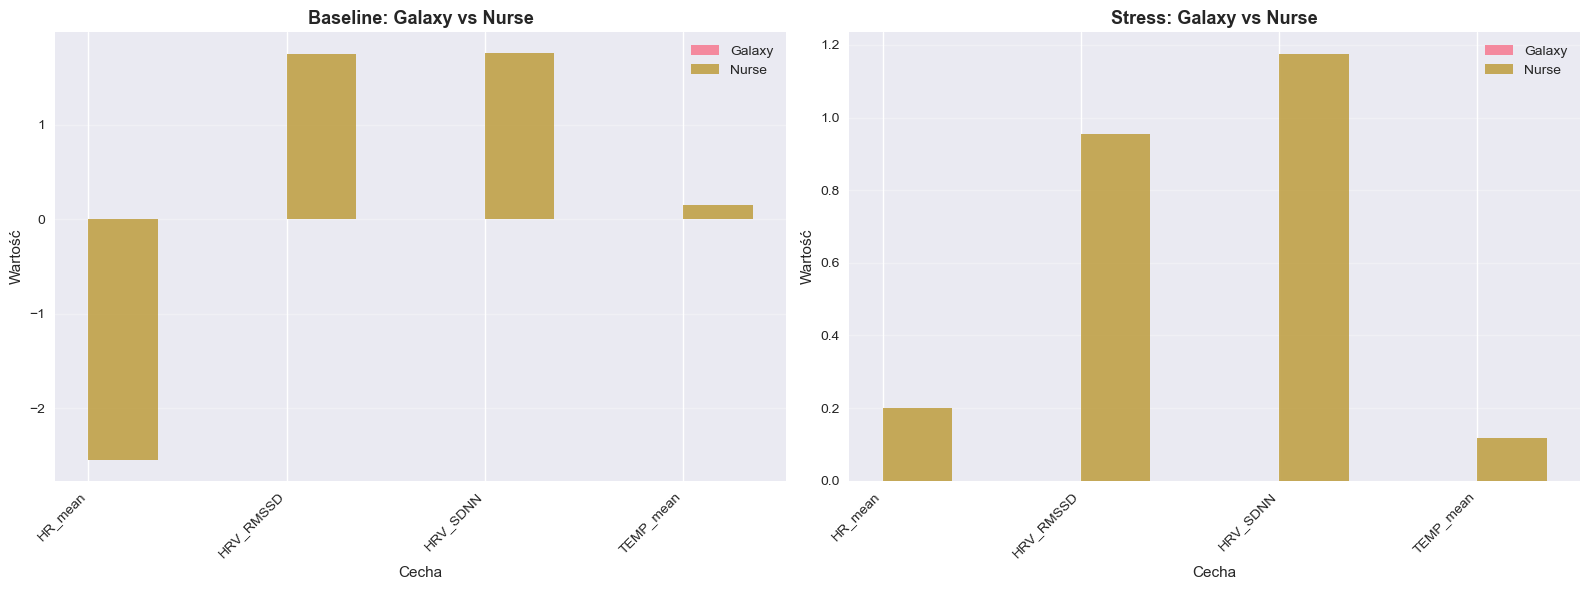


✅ Wizualizacje wygenerowane


In [107]:
# 🔹 WIZUALIZACJE
print(f"{'='*80}")
print(f"KROK 4: WIZUALIZACJE")
print(f"{'='*80}")

if df_results is None or df_results.empty:
    print("⚠️ Brak danych do wizualizacji")
else:
    # 1. Barplot: baseline (Galaxy vs Nurse) oraz stress (Galaxy vs Nurse)
    feature_cols = df_results['feature'].values
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Wykres 1: Baseline (Galaxy vs Nurse)
    ax1 = axes[0]
    x = np.arange(len(feature_cols))
    width = 0.35
    
    galaxy_baseline_vals = df_results['Galaxy_baseline'].values
    nurse_baseline_vals = df_results['Nurse_baseline'].values
    
    bars1 = ax1.bar(x - width/2, galaxy_baseline_vals, width, label='Galaxy', alpha=0.8)
    bars2 = ax1.bar(x + width/2, nurse_baseline_vals, width, label='Nurse', alpha=0.8)
    
    ax1.set_xlabel('Cecha', fontsize=11)
    ax1.set_ylabel('Wartość', fontsize=11)
    ax1.set_title('Baseline: Galaxy vs Nurse', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(feature_cols, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Wykres 2: Stress (Galaxy vs Nurse)
    ax2 = axes[1]
    galaxy_stress_vals = df_results['Galaxy_stress'].values
    nurse_stress_vals = df_results['Nurse_stress'].values
    
    bars3 = ax2.bar(x - width/2, galaxy_stress_vals, width, label='Galaxy', alpha=0.8)
    bars4 = ax2.bar(x + width/2, nurse_stress_vals, width, label='Nurse', alpha=0.8)
    
    ax2.set_xlabel('Cecha', fontsize=11)
    ax2.set_ylabel('Wartość', fontsize=11)
    ax2.set_title('Stress: Galaxy vs Nurse', fontsize=13, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(feature_cols, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Radar plot: Galaxy_change vs Nurse_change (znormalizowane min-max)
    from sklearn.preprocessing import MinMaxScaler
    
    # Przygotuj dane do radar plotu (tylko zmiany)
    changes_data = df_results[['feature', 'Galaxy_change', 'Nurse_change']].copy()
    changes_data = changes_data.dropna()
    
    if not changes_data.empty:
        features = changes_data['feature'].values
        galaxy_changes = changes_data['Galaxy_change'].values.reshape(-1, 1)
        nurse_changes = changes_data['Nurse_change'].values.reshape(-1, 1)
        
        # Normalizacja min-max
        scaler = MinMaxScaler()
        galaxy_changes_norm = scaler.fit_transform(galaxy_changes).flatten()
        nurse_changes_norm = scaler.fit_transform(nurse_changes).flatten()
        
        # Kąty dla radar plotu
        angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
        angles += angles[:1]  # Zamknij okrąg
        galaxy_changes_norm = np.concatenate([galaxy_changes_norm, [galaxy_changes_norm[0]]])
        nurse_changes_norm = np.concatenate([nurse_changes_norm, [nurse_changes_norm[0]]])
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        ax.plot(angles, galaxy_changes_norm, 'o-', linewidth=2, label='Galaxy', color='blue')
        ax.fill(angles, galaxy_changes_norm, alpha=0.15, color='blue')
        
        ax.plot(angles, nurse_changes_norm, 'o-', linewidth=2, label='Nurse', color='red')
        ax.fill(angles, nurse_changes_norm, alpha=0.15, color='red')
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, fontsize=10)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.5, 1])
        ax.set_yticklabels(['Min', '0.5', 'Max'], fontsize=9)
        ax.grid(True)
        ax.set_title('Zmiany: Galaxy vs Nurse\n(znormalizowane min-max)', fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n✅ Wizualizacje wygenerowane")
    print(f"{'='*80}")

## KROK 8: Interaktywny Streamlit (opcjonalny)

Aby uruchomić interaktywną aplikację Streamlit:

```bash
streamlit run galaxy_nurse_individual_trends_streamlit.py
```

Plik Streamlit (`galaxy_nurse_individual_trends_streamlit.py`) jest już utworzony w katalogu notebooks.

**Funkcje aplikacji:**
- Wybór datasetu (Galaxy / Nurse / Oba)
- Wybór uczestnika
- Wybór cech do wyświetlenia
- Wykresy interaktywne (line plots)
- Tabela zmian procentowych
- Interpretacja trendów

**Wymagania:**
- Plik `results/individual_trends_results.csv` musi być wygenerowany (uruchom kroki 1-7 tego notebooka)
